# Chem 277B - Fall 2024 - Homework 5
## ANN - Artificial Neural Networks
*Submit this notebook to bCourses to receive a credit for this assignment.*
<br>
due: **Oct 29th 2024** 
<br>
**Please upload both, the .ipynb file and the corresponding .pdf**<br>
<br>

## 60 Points Total

The goal of this homework assignment is to understand how the complexity of the dataset and the design of the ANN (number of neurons and number of layers) with different parameters i.e. like learning rate and activation functions influence the performance of the ANN.<br>
**Important: Only use numpy for creating the ANN, pandas for data frames if neccessary and matplotlib/ seaborn for plotting, but no further external python libraries.**

**1) Create an artificial dataset, one for regression and one for classification each** <br>
Start with a data set similar to the molecule data set we have been using earlier with a moderate number of features (say five) and about 1000 data points.<br> 
Normalize the features between 0 and 1 for better convergence and split the dataset into **training and testing set**.

In [434]:
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#make artificial regression dataset
X_regression, y_regression = make_regression(n_samples = 1000, n_features = 5)
#normalize
scaler = MinMaxScaler()
X_regression = scaler.fit_transform(X_regression)
#Need to normalize Target values OMGGGG
y_regression = scaler.fit_transform(y_regression.reshape(-1, 1)).flatten()
# split into training and testing
X_regression_train, X_regression_test, y_regression_train, y_regression_test = train_test_split(X_regression, y_regression, test_size=0.2, random_state = 69)

#make classification dataset
X_class, y_class = make_classification(n_samples = 1000, n_features = 5, n_classes = 2)
#normalize
X_class = scaler.fit_transform(X_class)
#split into train and test
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X_class, y_class, test_size=0.2, random_state = 69)


In [435]:
df_regression_train = pd.DataFrame(X_regression_train, columns=[f'Feature_{i}' for i in range(X_regression_train.shape[1])])
df_regression_train['Target'] = y_regression_train

df_classification_train = pd.DataFrame(X_class_train, columns=[f'Feature_{i}' for i in range(X_class_train.shape[1])])
df_classification_train['Target'] = y_class_train

df_regression_train.head()
df_classification_train.head()

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Target
0,0.153154,0.338208,0.376595,0.835738,0.315743,0
1,0.537198,0.452844,0.237240,0.500552,0.282036,1
2,0.816262,0.614012,0.630592,0.175609,0.737042,1
3,0.414273,0.819308,0.684713,0.541554,0.683382,0
4,0.564213,0.528576,0.222567,0.477775,0.274943,1


1    500
0    500
dtype: int64


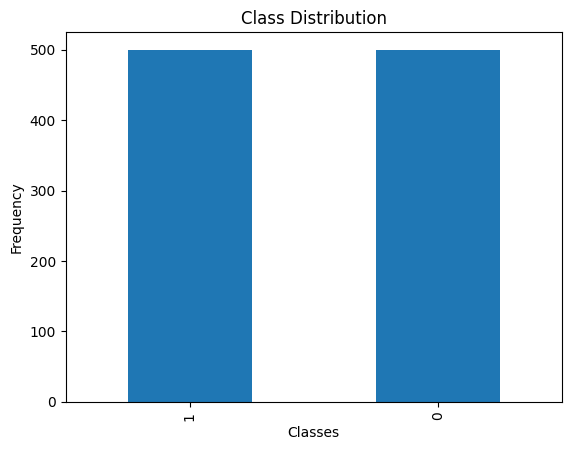

In [436]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming y_class is a numpy array or list, convert it to a pandas Series
y_class_series = pd.Series(y_class)

# Get the class distribution
class_distribution = y_class_series.value_counts()

# Print class distribution
print(class_distribution)

# Plotting the class distribution
class_distribution.plot(kind='bar')
plt.xlabel('Classes')

plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

**2) Network Design**<br>
Use at least two hidden layers and experiment with different layer sizes. Use different activation functions, such like *Sigmoid*, *ReLU* or any other activation function of your choice.<br>
Implement dropout between the hidden layers (e.g., randomly drop 20-30% neurons).<br>
Add an output layer according to the optimization problem (regression vs classification).

**3) Training and Optimization**<br>
For regression, use Mean Squared Error (MSE) as the loss function. For classification, use cross entropy as loss function (you can use the codes provided in the lecture). Implement backpropagation manually for weight updates and use gradient descent for optimization. Now, train the network over multiple epochs and track the loss and accuracy.

**4) Evaluation**<br>
Monitor the loss and the accuracy for the different epochs. For classification, generate a confusion chart and plot a histogramm of the different probabilities (see the lecture) at the end of the training process.<br>
Evaluate the performance of the ANN with the test set in the same way.<br>
<br>
Now, experiment with different<br>
- training to test set ratios<br>
- different numbers of features in the data (say, $N_{feature} = 3, 5, 20, 50$)
- features that correlate
- different numbers of data points (say, $N_{sample} = 200, 2\,000, 5\,000, 10\,000$)

How does the accuracy change?

In [437]:
#define all we need 
class Layer_Dense():
    
    def __init__(self, n_inputs, n_neurons):
        self.weights = np.random.randn(n_inputs, n_neurons)*0.01
        self.biases  = np.zeros((1, n_neurons))
        
    def forward(self, inputs):
        self.output  = np.dot(inputs, self.weights) + self.biases
        self.inputs  = inputs

    def backward(self, dvalues):
        #gradients
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases  = np.sum(dvalues, axis = 0, keepdims = True)
        self.dinputs  = np.dot(dvalues, self.weights.T)

class Activation_ReLU():
    
    def forward(self, inputs):
        self.output  = np.maximum(0, inputs)
        self.inputs  = inputs
        return self.output

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0 #ReLU derivative

class Activation_Sigmoid():
        
    def forward(self, inputs):
        self.output = np.clip(1/(1 + np.exp(-inputs)), 1e-7, 1-1e-7)
        self.inputs = inputs

    def backward(self, dvalues):
        sigm         = self.output
        deriv        = np.multiply(sigm, (1 - sigm))#inner derivative of sigmoid
        self.dinputs = np.multiply(deriv, dvalues)

class Activation_Softmax:
  
    def forward(self,inputs):
        self.inputs = inputs
        exp_values  = np.exp(inputs - np.max(inputs, axis = 1,\
                                      keepdims = True))#max in order to 
                                                       #prevent overflow
        #normalizing probs (Boltzmann dist.)
        probabilities = exp_values/np.sum(exp_values, axis = 1,\
                                      keepdims = True)  
        self.output   = probabilities                                                
    
    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)
        
        for i, (single_output, single_dvalues) in \
            enumerate(zip(self.output, dvalues)):
            
            single_output   = single_output.reshape(-1,1)
            jacobMatr       = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            self.dinputs[i] = np.dot(jacobMatr, single_dvalues)


class Loss:
     
     def calculate(self, output, y):
         
         sample_losses = self.forward(output, y)
         data_loss     = np.mean(sample_losses)
         return(data_loss)
    
    
class Loss_CategoricalCrossEntropy(Loss): 

     def forward(self, y_pred, y_true):
         samples = len(y_pred)
         #removing vals close to zero and one bco log and accuracy
         y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
         
         #now, depending on how classes are coded, we need to get the probs
         if len(y_true.shape) == 1:#classes are encoded as [[1],[2],[2],[4]]
             correct_confidences = y_pred_clipped[range(samples), y_true]
         elif len(y_true.shape) == 2:#classes are encoded as
                                    #[[1,0,0], [0,1,0], [0,1,0]]
             correct_confidences = np.sum(y_pred_clipped*y_true, axis = 1)
         #now: calculating actual losses
         negative_log_likelihoods = -np.log(correct_confidences)
         return(negative_log_likelihoods)
         
     def backward(self, dvalues, y_true):
         Nsamples = len(dvalues)
         Nlabels  = len(dvalues[0])
         #turning labels into one-hot i. e. [[1,0,0], [0,1,0], [0,1,0]], if
         #they are not
         if len(y_true.shape) == 1:
            y_true = np.eye(Nlabels)[y_true]
         #normalized gradient
         self.dinputs = -y_true/dvalues/Nsamples



#Creating a class as parent for softmax, loss and entropy classes. 
#Actually not neccessary, but saves code when building the ANN
class Activation_Softmax_Loss_CategoricalCrossentropy():
    
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss       = Loss_CategoricalCrossEntropy()
        
    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output#the probabilities
        #calculates and returns mean loss
        return(self.loss.calculate(self.output, y_true))
        
    def backward(self, dvalues, y_true):
        Nsamples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis = 1)
        self.dinputs = dvalues.copy()
        #calculating normalized gradient
        self.dinputs[range(Nsamples), y_true] -= 1
        self.dinputs = self.dinputs/Nsamples

class Optimizer_SGD:
    #initializing with a default learning rate of 0.01
    def __init__(self, learning_rate = 0.01, decay = 0, momentum = 0):
        self.learning_rate         = learning_rate
        self.current_learning_rate = learning_rate
        self.decay                 = decay
        self.iterations            = 0
        self.momentum              = momentum

        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1/ (1 + self.decay*self.iterations))
        
    def update_params(self, layer):
        
        #if we use momentum
        if self.momentum:
            
            #check if layer has attribute "momentum"
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums   = np.zeros_like(layer.biases)
                
            #now the momentum parts
            weight_updates = self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates
            
            bias_updates = self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
            
        else:
            
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates   = -self.current_learning_rate * layer.dbiases
        
        layer.weights += weight_updates
        layer.biases  += bias_updates
        
    def post_update_params(self):
        self.iterations += 1

#Make class to implement dropout
class Layer_Dropout:
    def __init__(self, drop):
        self.drop = drop #fraction to drop

    def forward(self, inputs, training):
        self.inputs = inputs
        if training:
            self.mask = np.random.binomial(1, 1-self.drop, size = inputs.shape)
            return inputs*self.mask
        else:
            return inputs*(1-self.drop)
        
    def backward(self, dvalues):
        self.dinputs = dvalues * self.mask

#Make class for Linear activation function
class Activation_Linear:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = inputs
    
    def backward(self,dvalues):
        self.dinputs = dvalues

class Loss_MeanSquaredError(Loss):
    def forward(self, y_pred, y_true):
        self.output = np.square(np.subtract(y_true,y_pred)).mean()
        return self.output

    def backward(self, dvalues, y_true):
        samples = len(dvalues)

        # If the output shape is (samples, 1), ensure y_true matches
        if y_true.shape != dvalues.shape:
            y_true = y_true.reshape(dvalues.shape)
            
        self.dinputs = (2*(dvalues-y_true))/samples 


In [438]:
#create ANN for classification dataset
#add second layer
Nneurons1     = 128
Nneurons2     = 64
Nsteps        = 10000 #number of iterations aka epochs

learning_rate = 0.2
decay         = 0.001
momentum      = 0.8

Nfeatures     = X_class_train.shape[1]
Nclasses      = 2

dense1        = Layer_Dense(Nfeatures, Nneurons1)
dropout_layer = Layer_Dropout(drop=0.3)
dense2        = Layer_Dense(Nneurons1, Nneurons2)
dense_cla     = Layer_Dense(Nneurons2, Nclasses) #for classification: Nclasses values for each data point

optimizer     = Optimizer_SGD(learning_rate = learning_rate, decay = decay, momentum = momentum)

ReLU           = Activation_ReLU()
ReLU2          = Activation_ReLU()
Sigm            = Activation_Sigmoid() #sigmoid for binary output
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy() #softmax for output layer with crossentropy

X = X_class_train
Target = y_class_train

In [439]:
Monitor = np.zeros((Nsteps,3)) #for storing loss, learning rate and accuracy

for epoch in range(Nsteps):
    #forward part:
    dense1.forward(X)
    ReLU.forward(dense1.output)
    dropout = dropout_layer.forward(ReLU.output, training = True)
    dense2.forward(dropout)
    ReLU2.forward(dense2.output)
    dense_cla.forward(ReLU2.output)
    loss = loss_activation.forward(dense_cla.output, Target)
    
    #comparing target to output
    predictions = np.argmax(loss_activation.output, axis = 1)
    accuracy    = np.mean(predictions == Target)

    
    #backward part:
    loss_activation.backward(loss_activation.output, Target)

    #loss_activation.dinputs = dL, i.e. the derivative of the loss, hence the outermost derivative
    dense_cla.backward(loss_activation.dinputs)
    ReLU2.backward(dense_cla.dinputs)
    dense2.backward(ReLU2.dinputs)
    dropout_layer.backward(dense2.dinputs)
    ReLU.backward(dropout_layer.dinputs)
    dense1.backward(ReLU.dinputs)
    
    #finally, we apply gradient descent to all learnables
    optimizer.pre_update_params()#decaying learning rate
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense_cla)
    optimizer.post_update_params()#just increasing iteration by one
            
    Monitor[epoch,0] = accuracy
    Monitor[epoch,1] = loss
    Monitor[epoch,2] = optimizer.current_learning_rate
            
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'accuracy: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'actual learning rate: {optimizer.current_learning_rate}')


epoch: 0, accuracy: 0.472, loss: 0.693, actual learning rate: 0.2
epoch: 100, accuracy: 0.502, loss: 0.693, actual learning rate: 0.18181818181818182
epoch: 200, accuracy: 0.902, loss: 0.234, actual learning rate: 0.16666666666666669
epoch: 300, accuracy: 0.909, loss: 0.229, actual learning rate: 0.15384615384615385
epoch: 400, accuracy: 0.922, loss: 0.204, actual learning rate: 0.14285714285714288
epoch: 500, accuracy: 0.936, loss: 0.192, actual learning rate: 0.13333333333333333
epoch: 600, accuracy: 0.938, loss: 0.187, actual learning rate: 0.125
epoch: 700, accuracy: 0.938, loss: 0.176, actual learning rate: 0.1176470588235294
epoch: 800, accuracy: 0.941, loss: 0.166, actual learning rate: 0.11111111111111112
epoch: 900, accuracy: 0.939, loss: 0.172, actual learning rate: 0.10526315789473684
epoch: 1000, accuracy: 0.943, loss: 0.162, actual learning rate: 0.1
epoch: 1100, accuracy: 0.936, loss: 0.169, actual learning rate: 0.09523809523809523
epoch: 1200, accuracy: 0.934, loss: 0.1

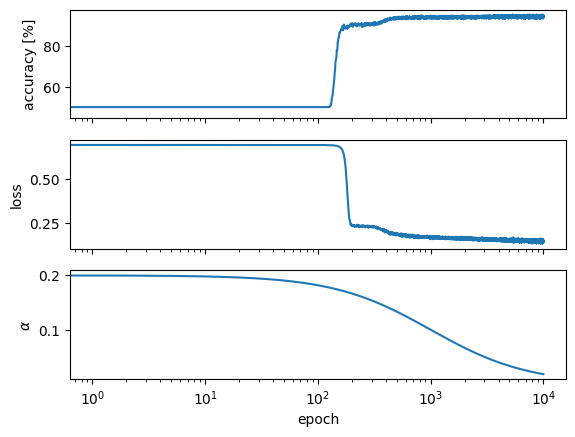

In [440]:
xplot = np.arange(Nsteps)

fig1, ax1 = plt.subplots(3, 1, sharex = True)
ax1[0].plot(xplot, 100*Monitor[:,0])
ax1[0].set_ylabel('accuracy [%]')
ax1[1].plot(xplot, Monitor[:,1])
ax1[1].set_ylabel('loss')
ax1[2].plot(xplot, Monitor[:,2])
ax1[2].set_ylabel(r'$\alpha$')
ax1[2].set_xlabel('epoch')
plt.xscale('log', base = 10)
plt.show()

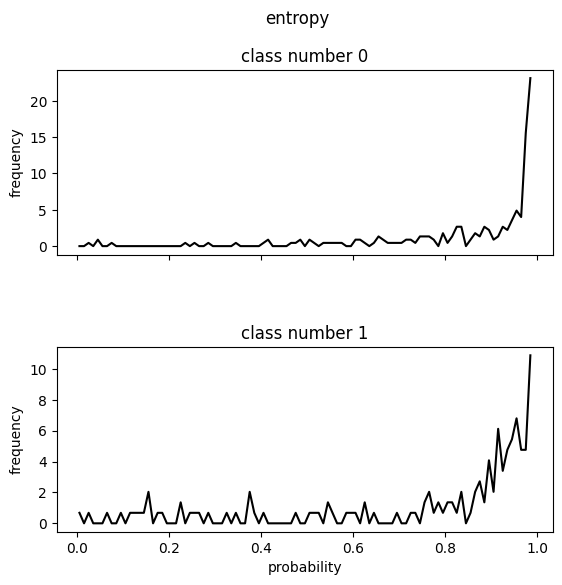

In [441]:
probabilities = loss_activation.output
ClassLabs     = np.arange(Nclasses)

fig2, ax2 = plt.subplots(Nclasses, 1, sharex = True)
fig2.set_figheight(6)
fig2.subplots_adjust(hspace = 0.5)
fig2.suptitle('entropy')
for L in ClassLabs:
    idx = np.argwhere(Target == L)[:,0]
    (value, where) = np.histogram(probabilities[idx,L],\
                                  bins = np.arange(0,1,0.01),\
                                  density = True)
    w = 0.5*(where[1:] + where[:-1])
    ax2[L].plot(w, value, 'k-')
    ax2[L].set_ylabel('frequency')
    ax2[L].set_title('class number ' + str(L))
ax2[Nclasses-1].set_xlabel('probability')
plt.show()

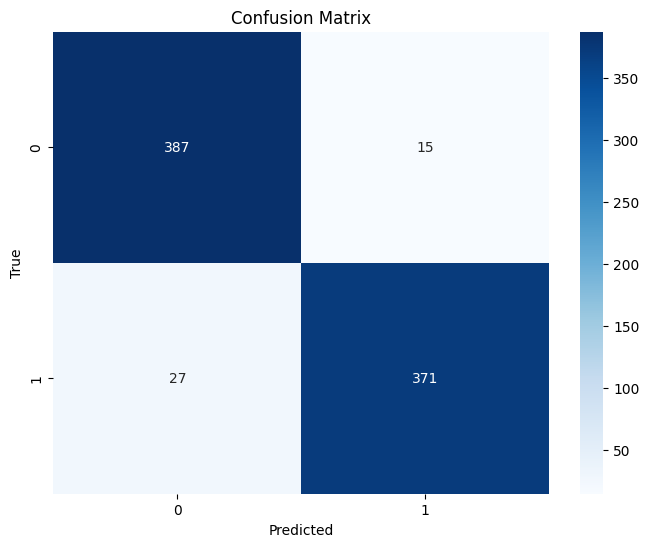

In [442]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
predicted_labels = np.argmax(probabilities, axis = 1)
cm               = confusion_matrix(Target, predicted_labels)

# Step 4: Plot confusion matrix
plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues',\
            xticklabels = ClassLabs, yticklabels = ClassLabs)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**Now evaluate with the test set in the same way:**

In [443]:
dense1.forward(X_class_test)
ReLU.forward(dense1.output)
dropout = dropout_layer.forward(ReLU.output, training = False)
dense2.forward(dropout)
ReLU2.forward(dense2.output)
dense_cla.forward(ReLU2.output)
loss = loss_activation.forward(dense_cla.output, y_class_test)
    
    #comparing target to output
predictions = np.argmax(loss_activation.output, axis = 1)
accuracy    = np.mean(predictions == y_class_test)

print(f'Test accuracy: {accuracy:.3f}')
print(f'Test loss: {loss:.3f}')

Test accuracy: 0.945
Test loss: 0.173


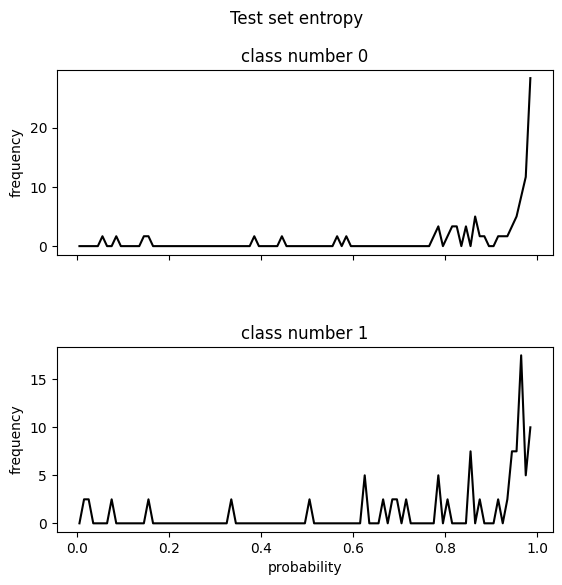

In [444]:
probabilities = loss_activation.output
ClassLabs     = np.arange(Nclasses)

fig2, ax2 = plt.subplots(Nclasses, 1, sharex = True)
fig2.set_figheight(6)
fig2.subplots_adjust(hspace = 0.5)
fig2.suptitle('Test set entropy')
for L in ClassLabs:
    idx = np.argwhere(y_class_test == L)[:,0]
    (value, where) = np.histogram(probabilities[idx,L],\
                                  bins = np.arange(0,1,0.01),\
                                  density = True)
    w = 0.5*(where[1:] + where[:-1])
    ax2[L].plot(w, value, 'k-')
    ax2[L].set_ylabel('frequency')
    ax2[L].set_title('class number ' + str(L))
ax2[Nclasses-1].set_xlabel('probability')
plt.show()

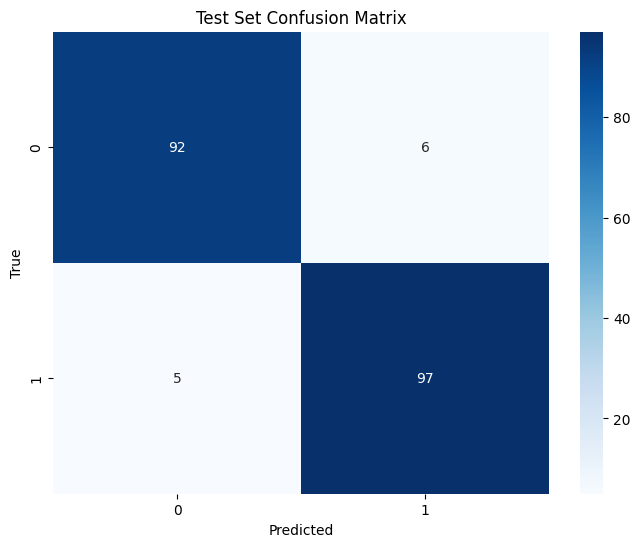

In [445]:
predicted_labels = np.argmax(probabilities, axis = 1)
cm               = confusion_matrix(y_class_test, predicted_labels)

# Step 4: Plot confusion matrix
plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues',\
            xticklabels = ClassLabs, yticklabels = ClassLabs)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix')
plt.show()

**Now try with sigmoid activation instead** <br>
Result: we end up with a plateau, so decreased the learning rate. Was still plateauing and returning lower accuracy and higher loss so ReLU is the winner!

In [446]:
#create ANN for classification dataset
#add second layer
Nneurons1     = 128
Nneurons2     = 64
Nsteps        = 2000 #number of iterations aka epochs

learning_rate = 0.2
decay         = 0.001
momentum      = 0.8

Nfeatures     = X_class_train.shape[1]
Nclasses      = 2

dense1        = Layer_Dense(Nfeatures, Nneurons1)
dropout_layer = Layer_Dropout(drop=0.3)
dense2        = Layer_Dense(Nneurons1, Nneurons2)
dense_cla     = Layer_Dense(Nneurons2, Nclasses) #for classification: Nclasses values for each data point

optimizer     = Optimizer_SGD(learning_rate = learning_rate, decay = decay, momentum = momentum)

Sigm            = Activation_Sigmoid() #sigmoid for binary output
Sigm2            = Activation_Sigmoid()
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy() #softmax for output layer with crossentropy

X = X_class_train
Target = y_class_train

In [447]:
Monitor = np.zeros((Nsteps,3)) #for storing loss, learning rate and accuracy

for epoch in range(Nsteps):
    #forward part:
    dense1.forward(X)
    Sigm.forward(dense1.output)
    dropout = dropout_layer.forward(Sigm.output, training = True)
    dense2.forward(dropout)
    Sigm2.forward(dense2.output)
    dense_cla.forward(Sigm2.output)
    loss = loss_activation.forward(dense_cla.output, Target)
    
    #comparing target to output
    predictions = np.argmax(loss_activation.output, axis = 1)
    accuracy    = np.mean(predictions == Target)

    
    #backward part:
    loss_activation.backward(loss_activation.output, Target)

    #loss_activation.dinputs = dL, i.e. the derivative of the loss, hence the outermost derivative
    dense_cla.backward(loss_activation.dinputs)
    Sigm2.backward(dense_cla.dinputs)
    dense2.backward(Sigm2.dinputs)
    dropout_layer.backward(dense2.dinputs)
    Sigm.backward(dropout_layer.dinputs)
    dense1.backward(Sigm.dinputs)
    
    #finally, we apply gradient descent to all learnables
    optimizer.pre_update_params()#decaying learning rate
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense_cla)
    optimizer.post_update_params()#just increasing iteration by one
            
    Monitor[epoch,0] = accuracy
    Monitor[epoch,1] = loss
    Monitor[epoch,2] = optimizer.current_learning_rate
            
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'accuracy: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'actual learning rate: {optimizer.current_learning_rate}')


epoch: 0, accuracy: 0.502, loss: 0.693, actual learning rate: 0.2
epoch: 100, accuracy: 0.502, loss: 0.693, actual learning rate: 0.18181818181818182
epoch: 200, accuracy: 0.502, loss: 0.693, actual learning rate: 0.16666666666666669
epoch: 300, accuracy: 0.502, loss: 0.693, actual learning rate: 0.15384615384615385
epoch: 400, accuracy: 0.502, loss: 0.693, actual learning rate: 0.14285714285714288
epoch: 500, accuracy: 0.502, loss: 0.693, actual learning rate: 0.13333333333333333
epoch: 600, accuracy: 0.502, loss: 0.693, actual learning rate: 0.125
epoch: 700, accuracy: 0.502, loss: 0.693, actual learning rate: 0.1176470588235294
epoch: 800, accuracy: 0.502, loss: 0.693, actual learning rate: 0.11111111111111112
epoch: 900, accuracy: 0.502, loss: 0.693, actual learning rate: 0.10526315789473684
epoch: 1000, accuracy: 0.502, loss: 0.693, actual learning rate: 0.1
epoch: 1100, accuracy: 0.502, loss: 0.693, actual learning rate: 0.09523809523809523
epoch: 1200, accuracy: 0.502, loss: 0.6

Now, experiment with different<br>
- training to test set ratios<br>
- different numbers of features in the data (say, $N_{feature} = 3, 5, 20, 50$)
- features that correlate
- different numbers of data points (say, $N_{sample} = 200, 2\,000, 5\,000, 10\,000$)

How does the accuracy change?

In [448]:
# Different training to test set ratio: Let's try 50/50
X_class50_train, X_class50_test, y_class50_train, y_class50_test = train_test_split(X_class, y_class, test_size=0.5, random_state = 69)

#train it 
X = X_class50_train
Target = y_class50_train
Nfeatures     = X_class50_train.shape[1]

Monitor = np.zeros((Nsteps,3)) #for storing loss, learning rate and accuracy

for epoch in range(Nsteps):
    #forward part:
    dense1.forward(X)
    ReLU.forward(dense1.output)
    dropout = dropout_layer.forward(ReLU.output, training = True)
    dense2.forward(dropout)
    ReLU2.forward(dense2.output)
    dense_cla.forward(ReLU2.output)
    loss = loss_activation.forward(dense_cla.output, Target)
    
    #comparing target to output
    predictions = np.argmax(loss_activation.output, axis = 1)
    accuracy    = np.mean(predictions == Target)

    
    #backward part:
    loss_activation.backward(loss_activation.output, Target)

    #loss_activation.dinputs = dL, i.e. the derivative of the loss, hence the outermost derivative
    dense_cla.backward(loss_activation.dinputs)
    ReLU2.backward(dense_cla.dinputs)
    dense2.backward(ReLU2.dinputs)
    dropout_layer.backward(dense2.dinputs)
    ReLU.backward(dropout_layer.dinputs)
    dense1.backward(ReLU.dinputs)
    
    #finally, we apply gradient descent to all learnables
    optimizer.pre_update_params()#decaying learning rate
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense_cla)
    optimizer.post_update_params()#just increasing iteration by one
            
    Monitor[epoch,0] = accuracy
    Monitor[epoch,1] = loss
    Monitor[epoch,2] = optimizer.current_learning_rate
            
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'accuracy: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'actual learning rate: {optimizer.current_learning_rate}')
        
#test it
dense1.forward(X_class50_test)
ReLU.forward(dense1.output)
dropout = dropout_layer.forward(ReLU.output, training = False)
dense2.forward(dropout)
ReLU2.forward(dense2.output)
dense_cla.forward(ReLU2.output)
loss = loss_activation.forward(dense_cla.output, y_class50_test)
    
    #comparing target to output
predictions = np.argmax(loss_activation.output, axis = 1)
accuracy    = np.mean(predictions == y_class50_test)

print(f'Test accuracy: {accuracy:.3f}')
print(f'Test loss: {loss:.3f}')


epoch: 0, accuracy: 0.494, loss: 0.693, actual learning rate: 0.06666666666666667
epoch: 100, accuracy: 0.778, loss: 0.679, actual learning rate: 0.06451612903225806
epoch: 200, accuracy: 0.898, loss: 0.253, actual learning rate: 0.0625
epoch: 300, accuracy: 0.902, loss: 0.234, actual learning rate: 0.0606060606060606
epoch: 400, accuracy: 0.900, loss: 0.237, actual learning rate: 0.05882352941176471
epoch: 500, accuracy: 0.906, loss: 0.236, actual learning rate: 0.05714285714285714
epoch: 600, accuracy: 0.912, loss: 0.224, actual learning rate: 0.05555555555555556
epoch: 700, accuracy: 0.910, loss: 0.223, actual learning rate: 0.05405405405405405
epoch: 800, accuracy: 0.924, loss: 0.207, actual learning rate: 0.05263157894736842
epoch: 900, accuracy: 0.930, loss: 0.196, actual learning rate: 0.051282051282051294
epoch: 1000, accuracy: 0.924, loss: 0.196, actual learning rate: 0.05
epoch: 1100, accuracy: 0.934, loss: 0.187, actual learning rate: 0.04878048780487806
epoch: 1200, accurac

**Lets increase our number of features**

In [449]:
#different number of features

#n=7
X_7class, y_7class = make_classification(n_samples = 1000, n_features = 7, n_classes = 2)
#normalize
X_7class = scaler.fit_transform(X_7class)
#split into train and test
X_7class_train, X_7class_test, y_7class_train, y_7class_test = train_test_split(X_7class, y_7class, test_size=0.2, random_state = 69)


In [450]:
#train and test for n=7

#train it 
X = X_7class_train
Target = y_7class_train

Nneurons1     = 128
Nneurons2     = 64
Nsteps        = 2000 #number of iterations aka epochs

learning_rate = 0.2
decay         = 0.001
momentum      = 0.8

Nfeatures     = X_7class_train.shape[1]
Nclasses      = 2

dense1        = Layer_Dense(Nfeatures, Nneurons1)
dropout_layer = Layer_Dropout(drop=0.3)
dense2        = Layer_Dense(Nneurons1, Nneurons2)
dense_cla     = Layer_Dense(Nneurons2, Nclasses) #for classification: Nclasses values for each data point


Monitor = np.zeros((Nsteps,3)) #for storing loss, learning rate and accuracy

for epoch in range(Nsteps):
    #forward part:
    dense1.forward(X)
    ReLU.forward(dense1.output)
    dropout = dropout_layer.forward(ReLU.output, training = True)
    dense2.forward(dropout)
    ReLU2.forward(dense2.output)
    dense_cla.forward(ReLU2.output)
    loss = loss_activation.forward(dense_cla.output, Target)
    
    #comparing target to output
    predictions = np.argmax(loss_activation.output, axis = 1)
    accuracy    = np.mean(predictions == Target)

    
    #backward part:
    loss_activation.backward(loss_activation.output, Target)

    #loss_activation.dinputs = dL, i.e. the derivative of the loss, hence the outermost derivative
    dense_cla.backward(loss_activation.dinputs)
    ReLU2.backward(dense_cla.dinputs)
    dense2.backward(ReLU2.dinputs)
    dropout_layer.backward(dense2.dinputs)
    ReLU.backward(dropout_layer.dinputs)
    dense1.backward(ReLU.dinputs)
    
    #finally, we apply gradient descent to all learnables
    optimizer.pre_update_params()#decaying learning rate
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense_cla)
    optimizer.post_update_params()#just increasing iteration by one
            
    Monitor[epoch,0] = accuracy
    Monitor[epoch,1] = loss
    Monitor[epoch,2] = optimizer.current_learning_rate
            
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'accuracy: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'actual learning rate: {optimizer.current_learning_rate}')
        
#test it
dense1.forward(X_7class_test)
ReLU.forward(dense1.output)
dropout = dropout_layer.forward(ReLU.output, training = False)
dense2.forward(dropout)
ReLU2.forward(dense2.output)
dense_cla.forward(ReLU2.output)
loss = loss_activation.forward(dense_cla.output, y_7class_test)
    
    #comparing target to output
predictions = np.argmax(loss_activation.output, axis = 1)
accuracy    = np.mean(predictions == y_7class_test)

print(f'Test accuracy: {accuracy:.3f}')
print(f'Test loss: {loss:.3f}')


epoch: 0, accuracy: 0.505, loss: 0.693, actual learning rate: 0.04000000000000001
epoch: 100, accuracy: 0.514, loss: 0.693, actual learning rate: 0.03921568627450981
epoch: 200, accuracy: 0.514, loss: 0.693, actual learning rate: 0.038461538461538464
epoch: 300, accuracy: 0.514, loss: 0.693, actual learning rate: 0.03773584905660378
epoch: 400, accuracy: 0.514, loss: 0.693, actual learning rate: 0.037037037037037035
epoch: 500, accuracy: 0.514, loss: 0.692, actual learning rate: 0.03636363636363637
epoch: 600, accuracy: 0.514, loss: 0.691, actual learning rate: 0.03571428571428571
epoch: 700, accuracy: 0.514, loss: 0.685, actual learning rate: 0.03508771929824561
epoch: 800, accuracy: 0.831, loss: 0.566, actual learning rate: 0.03448275862068966
epoch: 900, accuracy: 0.860, loss: 0.338, actual learning rate: 0.03389830508474576
epoch: 1000, accuracy: 0.873, loss: 0.336, actual learning rate: 0.03333333333333333
epoch: 1100, accuracy: 0.871, loss: 0.330, actual learning rate: 0.03278688

**Lets make a dataset with correlation**

In [451]:
#make classification dataset
X_corr_class, y_corr_class = make_classification(n_samples = 1000, n_features = 5, n_redundant =3, n_classes = 2)
#normalize
X_coorr_class = scaler.fit_transform(X_corr_class)
#split into train and test
X_corr_class_train, X_corr_class_test, y_corr_class_train, y_corr_class_test = train_test_split(X_corr_class, y_corr_class, test_size=0.2, random_state = 69)

In [452]:
#train it 
X = X_corr_class_train
Target = y_corr_class_train

Nneurons1     = 128
Nneurons2     = 64
Nsteps        = 2000 #number of iterations aka epochs

learning_rate = 0.2
decay         = 0.001
momentum      = 0.8

Nfeatures     = X_corr_class_train.shape[1]
Nclasses      = 2

dense1        = Layer_Dense(Nfeatures, Nneurons1)
dropout_layer = Layer_Dropout(drop=0.3)
dense2        = Layer_Dense(Nneurons1, Nneurons2)
dense_cla     = Layer_Dense(Nneurons2, Nclasses) #for classification: Nclasses values for each data point


Monitor = np.zeros((Nsteps,3)) #for storing loss, learning rate and accuracy

for epoch in range(Nsteps):
    #forward part:
    dense1.forward(X)
    ReLU.forward(dense1.output)
    dropout = dropout_layer.forward(ReLU.output, training = True)
    dense2.forward(dropout)
    ReLU2.forward(dense2.output)
    dense_cla.forward(ReLU2.output)
    loss = loss_activation.forward(dense_cla.output, Target)
    
    #comparing target to output
    predictions = np.argmax(loss_activation.output, axis = 1)
    accuracy    = np.mean(predictions == Target)

    
    #backward part:
    loss_activation.backward(loss_activation.output, Target)

    #loss_activation.dinputs = dL, i.e. the derivative of the loss, hence the outermost derivative
    dense_cla.backward(loss_activation.dinputs)
    ReLU2.backward(dense_cla.dinputs)
    dense2.backward(ReLU2.dinputs)
    dropout_layer.backward(dense2.dinputs)
    ReLU.backward(dropout_layer.dinputs)
    dense1.backward(ReLU.dinputs)
    
    #finally, we apply gradient descent to all learnables
    optimizer.pre_update_params()#decaying learning rate
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense_cla)
    optimizer.post_update_params()#just increasing iteration by one
            
    Monitor[epoch,0] = accuracy
    Monitor[epoch,1] = loss
    Monitor[epoch,2] = optimizer.current_learning_rate
            
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'accuracy: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'actual learning rate: {optimizer.current_learning_rate}')
        
#test it
dense1.forward(X_corr_class_test)
ReLU.forward(dense1.output)
dropout = dropout_layer.forward(ReLU.output, training = False)
dense2.forward(dropout)
ReLU2.forward(dense2.output)
dense_cla.forward(ReLU2.output)
loss = loss_activation.forward(dense_cla.output, y_corr_class_test)
    
    #comparing target to output
predictions = np.argmax(loss_activation.output, axis = 1)
accuracy    = np.mean(predictions == y_corr_class_test)

print(f'Test accuracy: {accuracy:.3f}')
print(f'Test loss: {loss:.3f}')


epoch: 0, accuracy: 0.475, loss: 0.693, actual learning rate: 0.02857142857142857
epoch: 100, accuracy: 0.507, loss: 0.692, actual learning rate: 0.02816901408450704
epoch: 200, accuracy: 0.679, loss: 0.682, actual learning rate: 0.02777777777777778
epoch: 300, accuracy: 0.881, loss: 0.289, actual learning rate: 0.0273972602739726
epoch: 400, accuracy: 0.886, loss: 0.278, actual learning rate: 0.027027027027027025
epoch: 500, accuracy: 0.887, loss: 0.276, actual learning rate: 0.02666666666666667
epoch: 600, accuracy: 0.896, loss: 0.270, actual learning rate: 0.02631578947368421
epoch: 700, accuracy: 0.890, loss: 0.267, actual learning rate: 0.025974025974025972
epoch: 800, accuracy: 0.890, loss: 0.268, actual learning rate: 0.025641025641025647
epoch: 900, accuracy: 0.902, loss: 0.260, actual learning rate: 0.025316455696202528
epoch: 1000, accuracy: 0.900, loss: 0.258, actual learning rate: 0.025
epoch: 1100, accuracy: 0.901, loss: 0.249, actual learning rate: 0.024691358024691357
ep

**lets double our number of datapoints**

In [453]:
#make classification dataset
X_double_class, y_double_class = make_classification(n_samples = 2000, n_features = 5, n_classes = 2)
#normalize
X_double_class = scaler.fit_transform(X_double_class)
#split into train and test
X_double_class_train, X_double_class_test, y_double_class_train, y_double_class_test = train_test_split(X_double_class, y_double_class, test_size=0.2, random_state = 69)


In [454]:
#train it 
X = X_double_class_train
Target = y_double_class_train

Nneurons1     = 128
Nneurons2     = 64
Nsteps        = 2000 #number of iterations aka epochs

learning_rate = 0.2
decay         = 0.001
momentum      = 0.8

Nfeatures     = X_double_class_train.shape[1]
Nclasses      = 2

dense1        = Layer_Dense(Nfeatures, Nneurons1)
dropout_layer = Layer_Dropout(drop=0.3)
dense2        = Layer_Dense(Nneurons1, Nneurons2)
dense_cla     = Layer_Dense(Nneurons2, Nclasses) #for classification: Nclasses values for each data point


Monitor = np.zeros((Nsteps,3)) #for storing loss, learning rate and accuracy

for epoch in range(Nsteps):
    #forward part:
    dense1.forward(X)
    ReLU.forward(dense1.output)
    dropout = dropout_layer.forward(ReLU.output, training = True)
    dense2.forward(dropout)
    ReLU2.forward(dense2.output)
    dense_cla.forward(ReLU2.output)
    loss = loss_activation.forward(dense_cla.output, Target)
    
    #comparing target to output
    predictions = np.argmax(loss_activation.output, axis = 1)
    accuracy    = np.mean(predictions == Target)

    
    #backward part:
    loss_activation.backward(loss_activation.output, Target)

    #loss_activation.dinputs = dL, i.e. the derivative of the loss, hence the outermost derivative
    dense_cla.backward(loss_activation.dinputs)
    ReLU2.backward(dense_cla.dinputs)
    dense2.backward(ReLU2.dinputs)
    dropout_layer.backward(dense2.dinputs)
    ReLU.backward(dropout_layer.dinputs)
    dense1.backward(ReLU.dinputs)
    
    #finally, we apply gradient descent to all learnables
    optimizer.pre_update_params()#decaying learning rate
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense_cla)
    optimizer.post_update_params()#just increasing iteration by one
            
    Monitor[epoch,0] = accuracy
    Monitor[epoch,1] = loss
    Monitor[epoch,2] = optimizer.current_learning_rate
            
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'accuracy: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'actual learning rate: {optimizer.current_learning_rate}')
        
#test it
dense1.forward(X_double_class_test)
ReLU.forward(dense1.output)
dropout = dropout_layer.forward(ReLU.output, training = False)
dense2.forward(dropout)
ReLU2.forward(dense2.output)
dense_cla.forward(ReLU2.output)
loss = loss_activation.forward(dense_cla.output, y_double_class_test)
    
    #comparing target to output
predictions = np.argmax(loss_activation.output, axis = 1)
accuracy    = np.mean(predictions == y_double_class_test)

print(f'Test accuracy: {accuracy:.3f}')
print(f'Test loss: {loss:.3f}')


epoch: 0, accuracy: 0.564, loss: 0.693, actual learning rate: 0.022222222222222223
epoch: 100, accuracy: 0.501, loss: 0.693, actual learning rate: 0.02197802197802198
epoch: 200, accuracy: 0.501, loss: 0.693, actual learning rate: 0.02173913043478261
epoch: 300, accuracy: 0.501, loss: 0.693, actual learning rate: 0.02150537634408602
epoch: 400, accuracy: 0.501, loss: 0.693, actual learning rate: 0.021276595744680854
epoch: 500, accuracy: 0.501, loss: 0.693, actual learning rate: 0.021052631578947368
epoch: 600, accuracy: 0.501, loss: 0.693, actual learning rate: 0.020833333333333336
epoch: 700, accuracy: 0.501, loss: 0.693, actual learning rate: 0.020618556701030927
epoch: 800, accuracy: 0.501, loss: 0.693, actual learning rate: 0.02040816326530612
epoch: 900, accuracy: 0.507, loss: 0.692, actual learning rate: 0.020202020202020204
epoch: 1000, accuracy: 0.613, loss: 0.691, actual learning rate: 0.020000000000000004
epoch: 1100, accuracy: 0.784, loss: 0.689, actual learning rate: 0.019

**Let's move on to the regression dataset!**
had to adjust learning rate, decay and moomentum in order to get a good moodel

In [455]:
#create ANN for regression dataset
#add second layer
Nneurons1     = 128
Nneurons2     = 64
Nsteps        = 2000 #number of iterations aka epochs

learning_rate = 0.001
decay         = 0.001
momentum      = 0.5

Nfeatures     = X_regression_train.shape[1]

dense1        = Layer_Dense(Nfeatures, Nneurons1)
dropout_layer = Layer_Dropout(drop=0.3)
dense2        = Layer_Dense(Nneurons1, Nneurons2)
dense_reg     = Layer_Dense(Nneurons2, 1) #for classification: Nclasses values for each data point

optimizer     = Optimizer_SGD(learning_rate = learning_rate, decay = decay, momentum = momentum)

ReLU          = Activation_ReLU()
ReLU2         = Activation_ReLU()
Lin           = Activation_Linear() #for regression output layer
loss_function = Loss_MeanSquaredError() 

X = X_regression_train
Target = y_regression_train

In [456]:
Monitor = np.zeros((Nsteps,3)) #for storing loss, learning rate and accuracy

for epoch in range(Nsteps):
    #forward part:
    dense1.forward(X)
    ReLU.forward(dense1.output)
    dropout = dropout_layer.forward(ReLU.output, training = True)
    dense2.forward(dropout)
    ReLU2.forward(dense2.output)
    dense_reg.forward(ReLU2.output)
    Lin.forward(dense_reg.output)


    loss = loss_function.forward(Lin.output, Target)
    
    #comparing target to output
    predictions = Lin.output
    mae = np.mean(np.abs(predictions - Target)) #monitoring metric, not used from training

    
    #backward part:
    loss_function.backward(Lin.output, Target)

    #loss_activation.dinputs = dL, i.e. the derivative of the loss, hence the outermost derivative
    Lin.backward(loss_function.dinputs)
    dense_reg.backward(Lin.dinputs)
    ReLU2.backward(dense_reg.dinputs)
    dense2.backward(ReLU2.dinputs)
    dropout_layer.backward(dense2.dinputs)
    ReLU.backward(dropout_layer.dinputs)
    dense1.backward(ReLU.dinputs)
    
    #finally, we apply gradient descent to all learnables
    optimizer.pre_update_params()#decaying learning rate
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense_reg)
    optimizer.post_update_params()#just increasing iteration by one
            
    Monitor[epoch,0] = mae
    Monitor[epoch,1] = loss
    Monitor[epoch,2] = optimizer.current_learning_rate
            
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'mae: {mae:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'actual learning rate: {optimizer.current_learning_rate}')


epoch: 0, mae: 0.483, loss: 0.261, actual learning rate: 0.001
epoch: 100, mae: 0.333, loss: 0.137, actual learning rate: 0.0009090909090909091
epoch: 200, mae: 0.245, loss: 0.082, actual learning rate: 0.0008333333333333334
epoch: 300, mae: 0.197, loss: 0.056, actual learning rate: 0.0007692307692307692
epoch: 400, mae: 0.169, loss: 0.043, actual learning rate: 0.0007142857142857143
epoch: 500, mae: 0.154, loss: 0.037, actual learning rate: 0.0006666666666666666
epoch: 600, mae: 0.145, loss: 0.033, actual learning rate: 0.000625
epoch: 700, mae: 0.141, loss: 0.031, actual learning rate: 0.000588235294117647
epoch: 800, mae: 0.138, loss: 0.030, actual learning rate: 0.0005555555555555556
epoch: 900, mae: 0.136, loss: 0.029, actual learning rate: 0.0005263157894736842
epoch: 1000, mae: 0.135, loss: 0.029, actual learning rate: 0.0005
epoch: 1100, mae: 0.135, loss: 0.029, actual learning rate: 0.0004761904761904762
epoch: 1200, mae: 0.134, loss: 0.028, actual learning rate: 0.00045454545

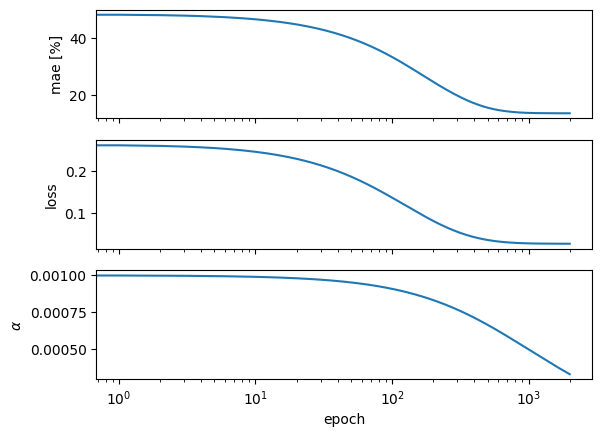

In [457]:
xplot = np.arange(Nsteps)

fig1, ax1 = plt.subplots(3, 1, sharex = True)
ax1[0].plot(xplot, 100*Monitor[:,0])
ax1[0].set_ylabel('mae [%]')
ax1[1].plot(xplot, Monitor[:,1])
ax1[1].set_ylabel('loss')
ax1[2].plot(xplot, Monitor[:,2])
ax1[2].set_ylabel(r'$\alpha$')
ax1[2].set_xlabel('epoch')
plt.xscale('log', base = 10)
plt.show()

In [458]:
#run on test set
# Assuming X_test and Target_test are your test inputs and true target values

# Forward pass on the test set
dense1.forward(X_regression_test)
ReLU.forward(dense1.output)
dropout = dropout_layer.forward(ReLU.output, training=False)  # Disable dropout for testing
dense2.forward(dropout)
ReLU2.forward(dense2.output)
dense_reg.forward(ReLU2.output)
Lin.forward(dense_reg.output)

# Calculate the test loss
test_loss = loss_function.forward(Lin.output, y_regression_test)

# Calculate the test MAE
test_predictions = Lin.output
test_mae = np.mean(np.abs(test_predictions - y_regression_test))

print(f'Test MAE: {test_mae:.3f}, Test Loss: {test_loss:.3f}')


Test MAE: 0.121, Test Loss: 0.023


noticing fluctuation in mae and loss, need to adjust parameters. 

Let's add another layer to see what happens. 

In [459]:
#create ANN for regression dataset
#add second layer
Nneurons1     = 128
Nneurons2     = 64
Nneurons3 = 16
Nsteps        = 5000 #number of iterations aka epochs

learning_rate = 0.001
decay         = 0.001
momentum      = 0.05

Nfeatures     = X_regression_train.shape[1]

dense1        = Layer_Dense(Nfeatures, Nneurons1)
dropout_layer = Layer_Dropout(drop=0.3)
dense2        = Layer_Dense(Nneurons1, Nneurons2)
dense3        = Layer_Dense(Nneurons2, Nneurons3)
dense_reg     = Layer_Dense(Nneurons3, 1) #for classification: Nclasses values for each data point

optimizer     = Optimizer_SGD(learning_rate = learning_rate, decay = decay, momentum = momentum)


ReLU          = Activation_ReLU()
ReLU2         = Activation_ReLU()
ReLU3         = Activation_ReLU()
Lin           = Activation_Linear() #for regression output layer
loss_function = Loss_MeanSquaredError() 

X = X_regression_train
Target = y_regression_train

In [460]:
Monitor = np.zeros((Nsteps,3)) #for storing loss, learning rate and accuracy

for epoch in range(Nsteps):
    #forward part:
    dense1.forward(X)
    ReLU.forward(dense1.output)
    dropout = dropout_layer.forward(ReLU.output, training = True)
    dense2.forward(dropout)
    ReLU2.forward(dense2.output)
    dense3.forward(ReLU2.output)
    ReLU3.forward(dense3.output)
    dense_reg.forward(ReLU3.output)
    Lin.forward(dense_reg.output)


    loss = loss_function.forward(Lin.output, Target)
    
    #comparing target to output
    predictions = Lin.output
    mae = np.mean(np.abs(predictions - Target)) #monitoring metric, not used from training

    
    #backward part:
    loss_function.backward(Lin.output, Target)

    #loss_activation.dinputs = dL, i.e. the derivative of the loss, hence the outermost derivative
    Lin.backward(loss_function.dinputs)
    dense_reg.backward(Lin.dinputs)
    ReLU3.backward(dense_reg.dinputs)
    dense3.backward(ReLU3.dinputs)
    ReLU2.backward(dense3.dinputs)
    dense2.backward(ReLU2.dinputs)
    dropout_layer.backward(dense2.dinputs)
    ReLU.backward(dropout_layer.dinputs)
    dense1.backward(ReLU.dinputs)
    
    #finally, we apply gradient descent to all learnables
    optimizer.pre_update_params()#decaying learning rate
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.update_params(dense_reg)
    optimizer.post_update_params()#just increasing iteration by one
            
    Monitor[epoch,0] = mae
    Monitor[epoch,1] = loss
    Monitor[epoch,2] = optimizer.current_learning_rate
            
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'mae: {mae:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'actual learning rate: {optimizer.current_learning_rate}')


epoch: 0, mae: 0.483, loss: 0.261, actual learning rate: 0.001
epoch: 100, mae: 0.396, loss: 0.184, actual learning rate: 0.0009090909090909091
epoch: 200, mae: 0.332, loss: 0.136, actual learning rate: 0.0008333333333333334
epoch: 300, mae: 0.284, loss: 0.105, actual learning rate: 0.0007692307692307692
epoch: 400, mae: 0.249, loss: 0.084, actual learning rate: 0.0007142857142857143
epoch: 500, mae: 0.224, loss: 0.070, actual learning rate: 0.0006666666666666666
epoch: 600, mae: 0.204, loss: 0.060, actual learning rate: 0.000625
epoch: 700, mae: 0.190, loss: 0.053, actual learning rate: 0.000588235294117647
epoch: 800, mae: 0.178, loss: 0.047, actual learning rate: 0.0005555555555555556
epoch: 900, mae: 0.169, loss: 0.043, actual learning rate: 0.0005263157894736842
epoch: 1000, mae: 0.162, loss: 0.040, actual learning rate: 0.0005
epoch: 1100, mae: 0.157, loss: 0.038, actual learning rate: 0.0004761904761904762
epoch: 1200, mae: 0.153, loss: 0.036, actual learning rate: 0.00045454545

Adding the extra layer actually made the model worse which means that it was probably too complex now for the small size of our dataset. Not really much better, so then I just played with my parameters, adjusting my learning and decay rate until mae was minimized. mae is plateauing even after messing with learning rate, try increasing complexity. Problem could also be our small dataset size